## Octave Convolution
- high frequency와 low frequency를 분류

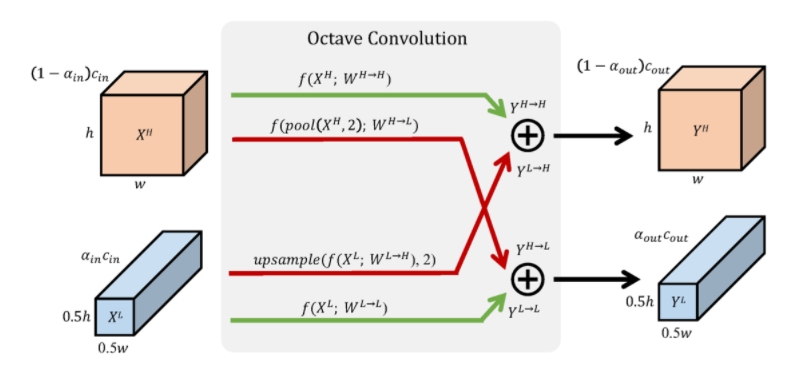

In [1]:
import torch
import torch.nn as nn


class OctaveConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, alpha=0.5, stride=1, padding=1, dilation=1,
                 groups=1, bias=False):
        super(OctaveConv, self).__init__()
        kernel_size = kernel_size[0]
        self.h2g_pool = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.stride = stride
        self.l2l = torch.nn.Conv2d(int(alpha * in_channels), int(alpha * out_channels),
                                   kernel_size, 1, padding, dilation, groups, bias)
        self.l2h = torch.nn.Conv2d(int(alpha * in_channels), out_channels - int(alpha * out_channels),
                                   kernel_size, 1, padding, dilation, groups, bias)
        self.h2l = torch.nn.Conv2d(in_channels - int(alpha * in_channels), int(alpha * out_channels),
                                   kernel_size, 1, padding, dilation, groups, bias)
        self.h2h = torch.nn.Conv2d(in_channels - int(alpha * in_channels),
                                   out_channels - int(alpha * out_channels),
                                   kernel_size, 1, padding, dilation, groups, bias)

    def forward(self, x):
        X_h, X_l = x

        if self.stride ==2:
            X_h, X_l = self.h2g_pool(X_h), self.h2g_pool(X_l)

        X_h2l = self.h2g_pool(X_h)

        X_h2h = self.h2h(X_h)
        X_l2h = self.l2h(X_l)

        X_l2l = self.l2l(X_l)
        X_h2l = self.h2l(X_h2l)
        
        X_l2h = self.upsample(X_l2h)
        X_h = X_l2h + X_h2h
        X_l = X_h2l + X_l2l

        return X_h, X_l


class FirstOctaveConv(nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size, alpha=0.5, stride=1, padding=1, dilation=1,
                 groups=1, bias=False):
        super(FirstOctaveConv, self).__init__()
        self.stride = stride
        kernel_size = kernel_size[0]
        self.h2g_pool = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        self.h2l = torch.nn.Conv2d(in_channels, int(alpha * out_channels),
                                   kernel_size, 1, padding, dilation, groups, bias)
        self.h2h = torch.nn.Conv2d(in_channels, out_channels - int(alpha * out_channels),
                                   kernel_size, 1, padding, dilation, groups, bias)

    def forward(self, x):
        if self.stride ==2:
            x = self.h2g_pool(x)

        X_h2l = self.h2g_pool(x)
        X_h = x
        X_h = self.h2h(X_h)
        X_l = self.h2l(X_h2l)

        return X_h, X_l


class LastOctaveConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, alpha=0.5, stride=1, padding=1, dilation=1,
                 groups=1, bias=False):
        super(LastOctaveConv, self).__init__()
        self.stride = stride
        kernel_size = kernel_size[0]
        self.h2g_pool = nn.AvgPool2d(kernel_size=(2,2), stride=2)

        self.l2h = torch.nn.Conv2d(int(alpha * in_channels), out_channels,
                                   kernel_size, 1, padding, dilation, groups, bias)
        self.h2h = torch.nn.Conv2d(in_channels - int(alpha * in_channels),
                                   out_channels,
                                   kernel_size, 1, padding, dilation, groups, bias)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        X_h, X_l = x

        if self.stride ==2:
            X_h, X_l = self.h2g_pool(X_h), self.h2g_pool(X_l)

        X_l2h = self.l2h(X_l)
        X_h2h = self.h2h(X_h)
        X_l2h = self.upsample(X_l2h)
        
        X_h = X_h2h + X_l2h

        return X_h

# batch normalization과 relu 적용 + octave conv
class OctaveCBR(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size=(3,3),alpha=0.5, stride=1, padding=1, dilation=1,
                 groups=1, bias=False, norm_layer=nn.BatchNorm2d):
        super(OctaveCBR, self).__init__()
        self.conv = OctaveConv(in_channels,out_channels,kernel_size, alpha, stride, padding, dilation, groups, bias)
        self.bn_h = norm_layer(int(out_channels*(1-alpha)))
        self.bn_l = norm_layer(int(out_channels*alpha))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_h, x_l = self.conv(x)
        x_h = self.relu(self.bn_h(x_h))
        x_l = self.relu(self.bn_l(x_l))
        return x_h, x_l


# batch normalization만 적용 + octave conv
class OctaveCB(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3), alpha=0.5, stride=1, padding=1, dilation=1,
                 groups=1, bias=False, norm_layer=nn.BatchNorm2d):
        super(OctaveCB, self).__init__()
        self.conv = OctaveConv(in_channels, out_channels, kernel_size, alpha, stride, padding, dilation,
                               groups, bias)
        self.bn_h = norm_layer(int(out_channels * (1 - alpha)))
        self.bn_l = norm_layer(int(out_channels * alpha))

    def forward(self, x):
        x_h, x_l = self.conv(x)
        x_h = self.bn_h(x_h)
        x_l = self.bn_l(x_l)
        return x_h, x_l

# batch normalization과 relu 적용 + octave conv
class FirstOctaveCBR(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3),alpha=0.5, stride=1, padding=1, dilation=1,
                 groups=1, bias=False,norm_layer=nn.BatchNorm2d):
        super(FirstOctaveCBR, self).__init__()
        self.conv = FirstOctaveConv(in_channels,out_channels,kernel_size, alpha,stride,padding,dilation,groups,bias)
        self.bn_h = norm_layer(int(out_channels * (1 - alpha)))
        self.bn_l = norm_layer(int(out_channels * alpha))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_h, x_l = self.conv(x)
        x_h = self.relu(self.bn_h(x_h))
        x_l = self.relu(self.bn_l(x_l))
        return x_h, x_l

# batch normalization + octave conv
class LastOCtaveCBR(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3), alpha=0.5, stride=1, padding=1, dilation=1,
                 groups=1, bias=False, norm_layer=nn.BatchNorm2d):
        super(LastOCtaveCBR, self).__init__()
        self.conv = LastOctaveConv(in_channels, out_channels, kernel_size, alpha, stride, padding, dilation, groups, bias)
        self.bn_h = norm_layer(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_h = self.conv(x)
        x_h = self.relu(self.bn_h(x_h))
        return x_h

# batch normalization + octave conv
class FirstOctaveCB(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3), alpha=0.5,stride=1, padding=1, dilation=1,
                 groups=1, bias=False, norm_layer=nn.BatchNorm2d):
        super(FirstOctaveCB, self).__init__()
        self.conv = FirstOctaveConv(in_channels,out_channels,kernel_size, alpha,stride,padding,dilation,groups,bias)
        self.bn_h = norm_layer(int(out_channels * (1 - alpha)))
        self.bn_l = norm_layer(int(out_channels * alpha))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_h, x_l = self.conv(x)
        x_h = self.bn_h(x_h)
        x_l = self.bn_l(x_l)
        return x_h, x_l

# batch normalization + octave conv
class LastOCtaveCB(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, alpha=0.5, stride=1, padding=1, dilation=1,
                 groups=1, bias=False, norm_layer=nn.BatchNorm2d):
        super(LastOCtaveCB, self).__init__()
        self.conv = LastOctaveConv( in_channels, out_channels, kernel_size, alpha, stride, padding, dilation, groups, bias)
        self.bn_h = norm_layer(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_h = self.conv(x)
        x_h = self.bn_h(x_h)
        return x_h

## Data Loader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import torch
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import transforms
import torch.utils.data as data
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.io import read_image
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".PNG", ".jpg", ".jpeg"])

class DatasetFromFolder(data.Dataset):
    def __init__(self, hr_image_dir, lr_image_dir):
        super(DatasetFromFolder, self).__init__()
        self.hr_path = hr_image_dir
        self.lr_path = lr_image_dir
        self.hr_path_list = sorted(os.listdir(hr_image_dir))
        self.lr_path_list = sorted(os.listdir(lr_image_dir))

    def __getitem__(self, idx):
        a = Image.open(os.path.join(self.hr_path, self.hr_path_list[idx])).convert('RGB')
        
        b = Image.open(os.path.join(self.lr_path, self.lr_path_list[idx])).convert('RGB')
        
        a = transforms.ToTensor()(a)
        b = transforms.ToTensor()(b)
        
        return b, a

    def __len__(self):
        return len(self.hr_path_list)

In [19]:
train_data = DatasetFromFolder("/content/drive/MyDrive/superresolution/dataset/DIV2K_train_HR/a", "/content/drive/MyDrive/superresolution/dataset/DIV2K_train_LR_bicubic/a")
valid_data = DatasetFromFolder("/content/drive/MyDrive/superresolution/dataset/set5", "/content/drive/MyDrive/superresolution/dataset/set5_lr")

In [20]:
train_loader = DataLoader(train_data, batch_size=8)
valid_loader = DataLoader(valid_data, batch_size=1)

## model

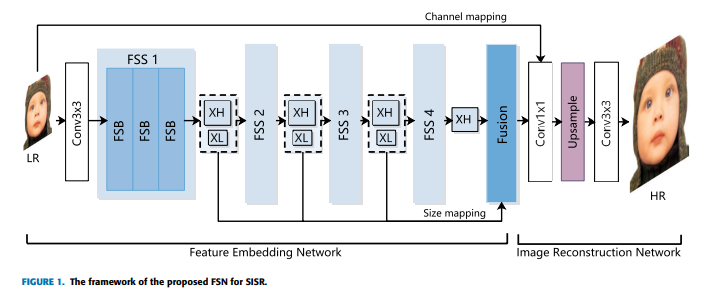

In [21]:
import torch.nn as nn

def _make_FSB(out_channel):
      return nn.Sequential(
          OctaveCBR(out_channel, out_channel).cuda(),
          OctaveCBR(out_channel, out_channel).cuda(),
          OctaveCB(out_channel, out_channel).cuda()
      )

class FSS(nn.Module):
  def __init__(self, out_channel):
    super(FSS, self).__init__()
    self.channel = out_channel
    self.relu = nn.ReLU()

  def forward(self, x, num_blocks):
    for _ in range(num_blocks):
      size_mapping = x
      layer = _make_FSB(self.channel)
      x = layer(x)
      x += size_mapping
      x = (self.relu(x[0]), self.relu(x[1]))
    return x


class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv_primary = nn.Conv2d(3, 64, 3, 1, 1)
        self.first_oct = FirstOctaveCBR(64, 256)
        self.FSS1_first = nn.Sequential(
            OctaveCBR(256, 256),
            OctaveCB(256, 256)
        )
        self.FSS1 = FSS(256)
        self.FSS2 = FSS(256)
        self.FSS3 = FSS(256)
        self.FSS4 = FSS(256)

        self.pp = OctaveCBR(256, 512)

        self.FSS4_final = nn.Sequential(
            OctaveCBR(512, 512),
            LastOCtaveCB(512, 512, (3, 3))
        )

        self.relu = nn.ReLU()

        self.conv1x1_4 = nn.Conv2d(256, 512, 1)
        self.up = nn.ConvTranspose2d(384, 512, 4, 2, 1)

        self.conv1x1_channel_mapping = nn.Conv2d(3, 512, 1)
        self.up2 = nn.ConvTranspose2d(512, 512, 4, 2, 1)

        self.conv3x3 = nn.Conv2d(512, 3, 3, 1, 1)
        self.sigmoid = nn.Sigmoid()

        self.hr_channel = nn.Conv2d(896, 512, 1)

    def forward(self, x):
        channel_mapping = x
        x = self.conv_primary(x)

        x = self.first_oct(x)
        FSS1_mapping = x
        x = self.FSS1_first(x)
        x += FSS1_mapping
        x = (self.relu(x[0]), self.relu(x[1]))
        x = self.FSS1(x, 2)
        first_output = x # (128, 128, 128), (128, 64, 64)

        x = self.FSS2(x, 4)
        second_output = x # (128, 128, 128), (128, 64, 64)

        x = self.FSS3(x, 6)
        third_output = x# (128, 128, 128), (128, 64, 64)

        x = self.FSS4(x, 2)
        x = self.pp(x)
        FSS4_mapping = self.conv1x1_4(x[0])
        x = self.FSS4_final(x)
        x = self.relu(x + FSS4_mapping)
        fourth_output = x # (512, 128, 128)
        
        fusion = self.hr_channel(torch.cat((first_output[0], second_output[0], third_output[0], fourth_output), dim=1)) + self.up(torch.cat((first_output[1], second_output[1], third_output[1]), dim=1))
        x = fusion + self.conv1x1_channel_mapping(channel_mapping)
        x = self.up2(x)
        x = self.sigmoid(self.conv3x3(x))
        return x

## Train

In [22]:
model = CustomModel().cuda()

In [23]:
import torch.optim as optim

In [24]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [25]:
epoch = 120

In [31]:
import math
import numpy as np

In [32]:
def psnr(label, outputs, max_val=1.):
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff)**2))
    if rmse == 0: # label과 output이 완전히 일치하는 경우
        return 100
    else:
        psnr = 20 * math.log10(max_val/rmse)
        return psnr

In [ ]:
import sys

import torch
from tqdm import tqdm

history = {
    'train_loss': [],
    'valid_loss': [],
}
for e in range(epoch):
    model.train()
    train_loss = 0
    cnt = 0
    total_psnr = 0
    pbar = tqdm(enumerate(train_loader), file=sys.stdout)
    for batch_idx, (data, target) in pbar:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        total_psnr += psnr(output, target)
        cnt += 1
        pbar.set_postfix(epoch=f'epoch {e + 1} of {epoch}', loss=f'{train_loss / cnt}, psnr = {total_psnr/cnt}')
    scheduler.step()
    pbar.close()

    train_loss = train_loss / len(train_loader)
    history['train_loss'].append(train_loss)

    if valid_loader is not None:
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.cuda(), target.cuda(),
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()
        history['valid_loss'].append(valid_loss)

7it [03:54, 38.83s/it, epoch=epoch 1 of 120, loss=0.02932597789913416, psnr = 15.56094310093604]